In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [35]:
df = pd.read_csv('tuulivoimatieto.csv')
df.columns = ['a','b','c','d','e']
df.drop(['b','c','d'], axis=1, inplace=True)
df.columns = ['datetime','Wind_MWh']
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.head()

,Wind_MWh
datetime,
2018-12-31 21:00:00,1598.0
2018-12-31 22:00:00,1552.0
2018-12-31 23:00:00,1468.0
2019-01-01 00:00:00,1427.0
2019-01-01 01:00:00,1352.0


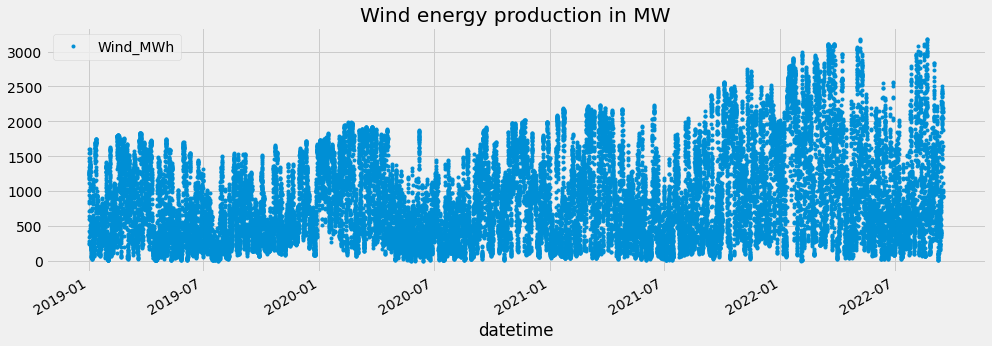

In [36]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Wind energy production in MW')
plt.show()

### Outlier detection and removal

<AxesSubplot:ylabel='Frequency'>

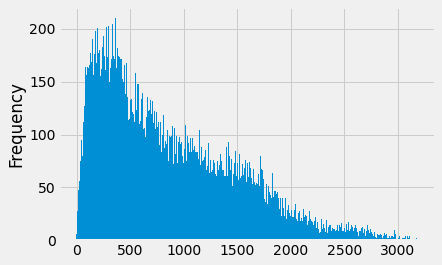

In [37]:
df['Wind_MWh'].plot(kind='hist', bins=500)

**Seems ok, no outliers removed**

### Save data to parquet file

In [38]:
df.to_parquet('processed_data/tuulivoima.parquet')

# Time series cross-validation

Since we only have data starting from 2019, we do 3 splits, 1 year each.

In [39]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=24*365*1, gap=24)
df = df.sort_index()

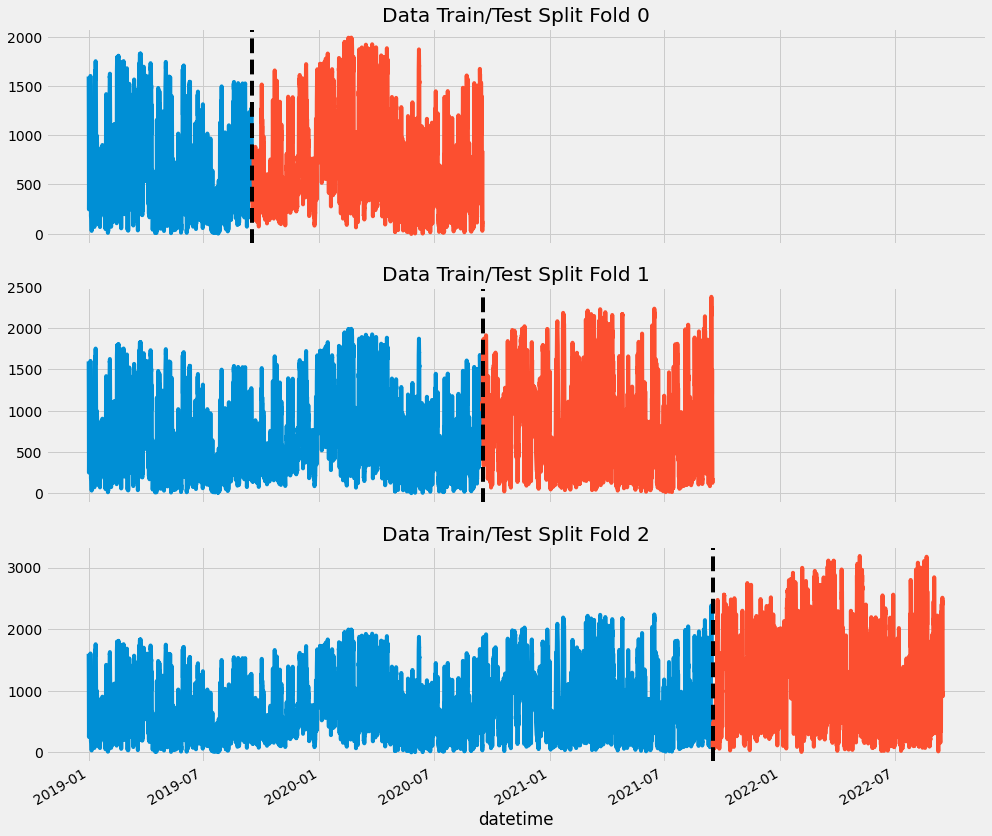

In [40]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Wind_MWh'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Wind_MWh'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [41]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Lag features

In [42]:
def add_lags(df):
    target_map = df['Wind_MWh'].to_dict()
    df['w_lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['w_lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['w_lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

## Box plot visualization

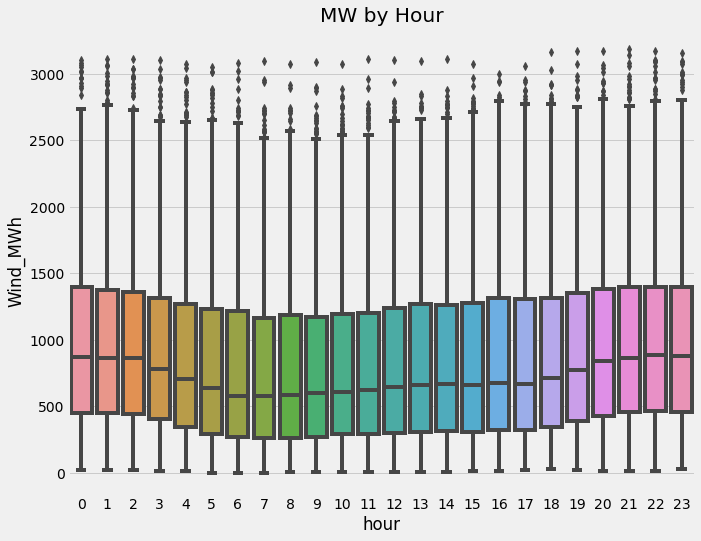

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Wind_MWh')
ax.set_title('MW by Hour')
plt.show()

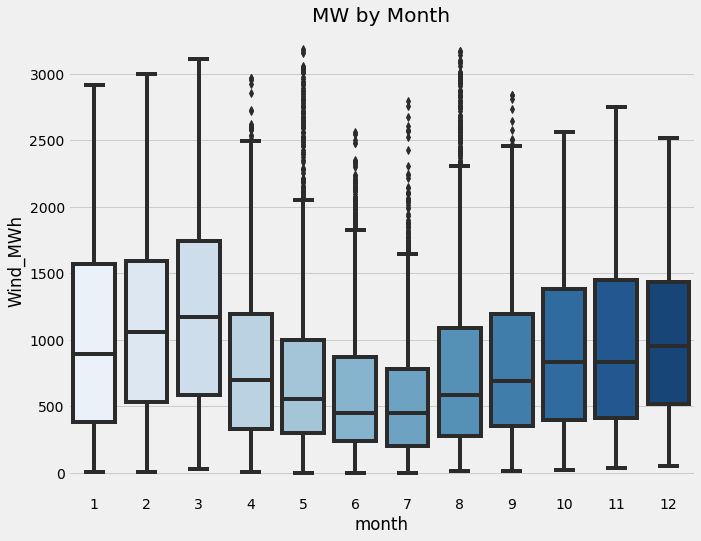

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Wind_MWh', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Train using cross-validation

In [46]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'w_lag1','w_lag2','w_lag3']
    TARGET = 'Wind_MWh'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor()
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:623.19851	validation_1-rmse:709.02749
[99]	validation_0-rmse:78.67576	validation_1-rmse:594.63368
[0]	validation_0-rmse:655.79220	validation_1-rmse:849.89044
[99]	validation_0-rmse:146.54227	validation_1-rmse:675.67563
[0]	validation_0-rmse:712.26435	validation_1-rmse:1220.94581
[99]	validation_0-rmse:193.11972	validation_1-rmse:906.44212


In [47]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 725.5838
Fold scores:[594.6336810424476, 675.6756276881272, 906.4421150493838]


## Predicting the future

- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [51]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'w_lag1','w_lag2','w_lag3']
TARGET = 'Wind_MWh'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = XGBRegressor(n_estimators=1000)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:844.11326
[100]	validation_0-rmse:249.64968
[200]	validation_0-rmse:187.75470
[300]	validation_0-rmse:152.23799
[400]	validation_0-rmse:130.08896
[500]	validation_0-rmse:112.64871
[600]	validation_0-rmse:99.84813
[700]	validation_0-rmse:88.44281
[800]	validation_0-rmse:78.90382
[900]	validation_0-rmse:72.53281
[999]	validation_0-rmse:67.15241


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [49]:
df.index.max()

Timestamp('2022-09-15 13:00:00')

In [52]:
# Create future dataframe
future = pd.date_range(df.index.max(),'2023-01-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

In [53]:
future_w_features['Wind_MWh'] = reg.predict(future_w_features[FEATURES])

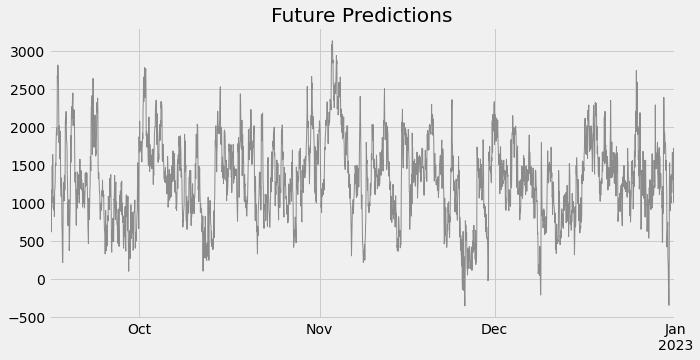

In [54]:
future_w_features['Wind_MWh'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

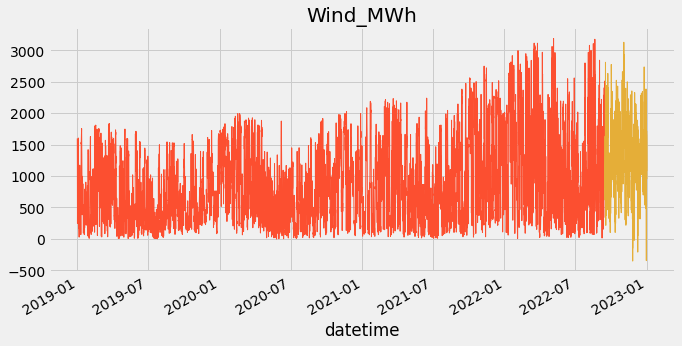

In [55]:
ax = df['Wind_MWh'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1)
future_w_features['Wind_MWh'].plot(ax=ax, color=color_pal[2],ms=1,lw=1, title='Wind_MWh')
plt.show()  

In [56]:
future_w_features[['Wind_MWh','w_lag1','w_lag2','w_lag3']].to_parquet('../future_data/wind.parquet')